In [1]:
# set dependencies
import os
import csv
import requests
import json
import time
import gmaps
import sqlalchemy
import psycopg2
import pymongo

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from datetime import date
from flask_pymongo import PyMongo
from splinter import Browser
from bs4 import BeautifulSoup
from flask import Flask, render_template, redirect
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float, Date
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from matplotlib import style
from scipy import stats
from pprint import pprint
from scipy.stats import linregress
from citipy import citipy

###from api_keys import weather_api_key
##from api_keys import g_key

pd.options.display.float_format = '{:,.2f}'.format


### Import Data

In [3]:
# Create dataframe from csv
vlcns = "dataFiles/Volcanos.csv"
vlcns =  pd.read_csv(vlcns)
vlcns.head(5)

,birthMonth,birthDay,birthYear,First year,Countries Active,num_country,Years Active,Start Year,End Year,Proven Victims,Possible Victims
0,4.00,21.00,"1,810.00",0.00,United Kingdom,1,1855-1861,"1,855.00","1,861.00",3.00,3.00
1,10.00,17.00,"1,821.00",0.00,Spain,1,1870-1879,"1,870.00","1,879.00",6.00,6.00
2,12.00,24.00,"1,825.00",0.00,United States,1,1863-1871,"1,863.00","1,871.00",12.00,12.00
3,1.00,28.00,"1,828.00",0.00,United States,1,1850-1864,"1,850.00","1,864.00",11.00,11.00
4,9.00,9.00,"1,839.00",0.00,Netherlands,1,1880-1883,"1,880.00","1,883.00",27.00,90.00


### Test the function

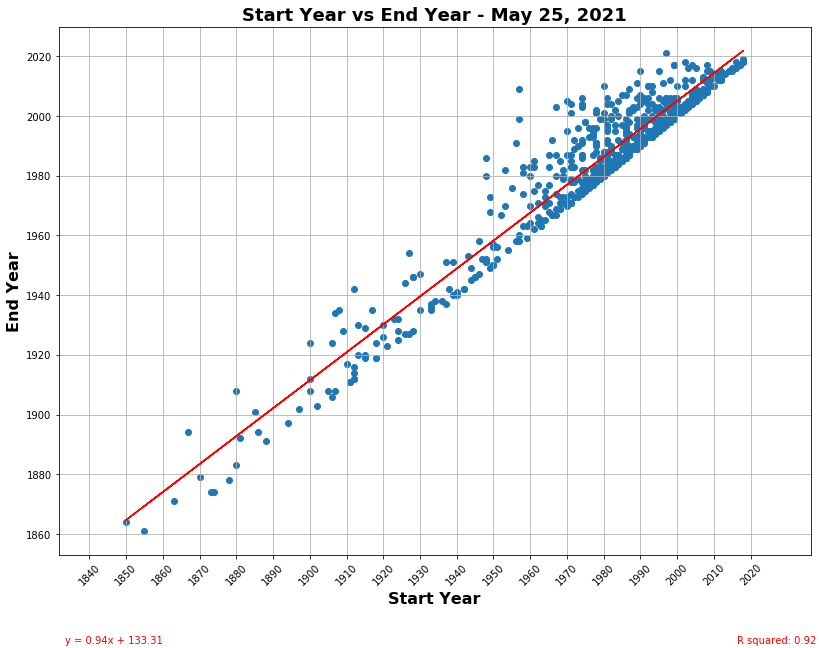

In [4]:
# Drop Rows with NaN from columns to be graphed or linear regression will produce NaN values
sbc_plot_scatter(vlcns,'Start Year','End Year')

In [5]:
# Create city list from CSV 2 columns: city names and count for heatmap
#cities_df =  pd.read_csv('dataFiles/cities_SBC_clean.csv')
# Dont Run this cell unless necessary, it takes about 30 min to run
#cities_counts=cities_df.value_counts()
#cities_counts_df=pd.DataFrame(cities_df.City.value_counts().reset_index())
#cities_counts_df.columns=['City','count']
#city_list=cities_counts_df['City'].to_list()

# Create city list from manual entry.
city_list=['Denver', 'Moscow']
# Set up URL
root_url=f'http://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&units=imperial&q='

# Set up lists and counters
name=[]
lat=[]
lon=[]
i=j=1

# loop to get lat lons
for city in city_list:
    response=requests.get(root_url+city).json()
    try:
        print(f'Getting city {i} of Batch {j} | {city}')
        name.append(response['name'])
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        
        i+=1
        if i>50:
            j+=1
            i=1
            time.sleep(1)
    except:
        print(f'Unable to retrieve data for {city}')
print('Finished getting data......................')

Getting city 1 of Batch 1 | Denver
Getting city 2 of Batch 1 | Moscow
Finished getting data......................


In [6]:
map=pd.DataFrame({'City':name,'Lat':lat,'Lon':lon})
map['count']=[100,100]

In [7]:
# Generate Location from City
# Generate city list, split column into individual cities, count cities per killer, divide # victims by killers per city count
#map=pd.read_csv('dataFiles/MUST_HAVE_Lat_Lon_columns.csv',low_memory=False)
map=map.dropna(subset=['Lat','Lon'])
# Configure gmaps
gmaps.configure(api_key=g_key)
# Style and create map
max_intensity=max(map['count'])
style={'width':"100%",'height':'500px','border':'5px solid black','padding':'5px','margin':'0 auto 0 auto'}
fig=gmaps.figure(layout=style, center=(30,-104),zoom_level=3)
heat_layer=gmaps.heatmap_layer(map[['Lat','Lon']],weights=map['count'],max_intensity=max(map['count']),point_radius=1.0,
                               dissipating=False)
# Add layer
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='5px solid black', height='500px', margin='0 auto 0 auto', padding='5px', wi…